># A framework to estimate Chorus waves (Chorus wave global maps) in from low-Earth-orbit, Van Allen Probe and other datasets.

>- September, 2021. S. Chakraborty(<shibaji7@vt.edu>), G. S. Cunninghum
>- Data Analysis for one month worth data for GMM study

In [16]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import glob
from matplotlib.colors import LogNorm

def get_gridded_parameters(q, xparam, yparam, zparam, r=0):
    plotParamDF = q[ [xparam, yparam, zparam] ]
    plotParamDF[xparam] = np.round(plotParamDF[xparam].tolist(), r)
    plotParamDF[yparam] = np.round(plotParamDF[yparam].tolist(), r)
    plotParamDF = plotParamDF.groupby( [xparam, yparam] ).mean().reset_index()
    plotParamDF = plotParamDF[ [xparam, yparam, zparam] ].pivot( xparam, yparam )
    x = plotParamDF.index.values
    y = plotParamDF.columns.levels[1].values
    X, Y  = np.meshgrid( x, y )
    # Mask the nan values! pcolormesh can't handle them well!
    Z = np.ma.masked_where(
            np.isnan(plotParamDF[zparam].values),
            plotParamDF[zparam].values)
    return X,Y,Z

def contour_f(x, y, z, fig, ax, xlab, ylab):
    ax.contourf(x, y, z.T, cmap="RdGy")
    norm = LogNorm(vmax=1e2, vmin=1e0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    pos = ax.get_position()
    cpos = [pos.x1 + 0.025, pos.y0 + 0.0125,
            0.015, pos.height * 0.8]                # this list defines (left, bottom, width, height
    cax = fig.add_axes(cpos)
    cb2 = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.RdGy, norm=norm, spacing="uniform", orientation="vertical")
    cb2.set_label("B, nT")
    return

In [6]:
# Get and preprocess the whole dataset
inputs = ["MLAT", "MLT", "L", "Lstar", "AE", "mod"]
outputs = ["log.B(pT)"]
files = glob.glob("tmp/*.csv")
dat = pd.DataFrame()
files.sort()
for f in files:
    dat = pd.concat([dat, pd.read_csv(f, parse_dates=["epoch"])])
dat["mod"] = dat.epoch.apply(lambda x: x.hour*60 + x.minute) # Define minute of a day
dat["sod"] = dat.epoch.apply(lambda x: x.hour*3600 + x.minute*60 + x.second) # Define seconds of a day
dat["log.B(pT)"] = np.log10(dat["B(pT)"])
dat.head()

/home/shibaji/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,epoch,SAT,L,Lstar,R,MLAT,MLON,MLT,Fce,Bl(pT),Bu(pT),B(pT),AE,mod,sod,log.B(pT)
0,2012-10-01 00:00:00,A,6.103,5.661,-8.740,10.236,176.200,7.047,3479.59,84.118,1.890,84.155,448,0,0,1.925080
1,2012-10-01 00:01:00,A,6.105,5.663,-8.875,10.295,176.110,7.057,3476.28,101.134,1.259,101.139,442,1,60,2.004919
2,2012-10-01 00:02:00,A,6.107,5.665,-9.010,10.354,176.021,7.068,3473.19,183.556,2.911,183.596,454,2,120,2.263863
3,2012-10-01 00:03:00,A,6.109,5.667,-9.145,10.413,175.931,7.079,3470.31,82.164,1.063,82.175,470,3,180,1.914740
4,2012-10-01 00:04:00,A,6.111,5.668,-9.280,10.472,175.841,7.089,3467.64,151.897,2.066,151.906,484,4,240,2.181575


In [7]:
# Describe the whole dataset
dat[inputs+outputs].describe()

,MLAT,MLT,L,Lstar,AE,mod,log.B(pT)
count,3.325777e+06,3.325777e+06,3.325777e+06,3.325441e+06,3.332160e+06,3.332160e+06,3.325777e+06
mean,-2.747294e-01,1.250411e+01,4.417284e+00,4.202413e+00,1.689472e+02,7.195000e+02,-inf
std,7.586931e+00,7.077429e+00,1.527836e+00,1.370223e+00,1.992195e+02,4.156922e+02,NaN
min,-2.018700e+01,8.000000e-03,9.870000e-01,1.105000e+00,2.000000e+00,0.000000e+00,-inf
25%,-5.313000e+00,6.121000e+00,3.316000e+00,3.275000e+00,4.400000e+01,3.597500e+02,2.077549e-02
50%,-4.700000e-01,1.305700e+01,4.904000e+00,4.669000e+00,8.500000e+01,7.195000e+02,1.908917e-01
75%,4.851000e+00,1.870200e+01,5.708000e+00,5.334000e+00,2.180000e+02,1.079250e+03,5.735678e-01
max,2.017200e+01,2.400000e+01,6.913000e+00,6.390000e+00,2.803000e+03,1.439000e+03,3.227419e+00


In [8]:
# Drop nan and infinitites
dat = dat[~dat.isin([np.nan, np.inf, -np.inf]).any(1)]
# Describe the whole dataset
dat[inputs+outputs].describe()

,MLAT,MLT,L,Lstar,AE,mod,log.B(pT)
count,2.946740e+06,2.946740e+06,2.946740e+06,2.946740e+06,2.946740e+06,2.946740e+06,2.946740e+06
mean,-3.533100e-01,1.257372e+01,4.794893e+00,4.549920e+00,1.691588e+02,7.194935e+02,4.312894e-01
std,7.681701e+00,7.103968e+00,1.171582e+00,1.023919e+00,1.995949e+02,4.157123e+02,4.976113e-01
min,-2.018700e+01,8.000000e-03,2.024000e+00,2.032000e+00,2.000000e+00,0.000000e+00,-8.728952e-01
25%,-5.482000e+00,6.106000e+00,3.965000e+00,3.859000e+00,4.400000e+01,3.590000e+02,9.025805e-02
50%,-6.420000e-01,1.324600e+01,5.150000e+00,4.873000e+00,8.500000e+01,7.190000e+02,2.516382e-01
75%,4.944000e+00,1.880000e+01,5.752000e+00,5.371000e+00,2.190000e+02,1.080000e+03,6.494322e-01
max,2.017200e+01,2.400000e+01,6.913000e+00,6.390000e+00,2.803000e+03,1.439000e+03,3.227419e+00


Text(0, 0.5, 'Values(params)')

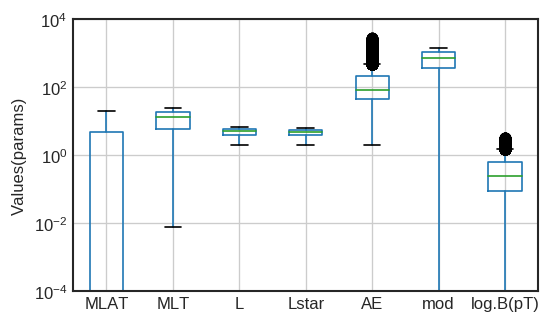

In [9]:
# Generate the boxplots
fig = plt.figure(dpi=120, figsize=(5,3))
ax = fig.add_subplot(111)
dat[inputs+outputs].boxplot(ax=ax)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e4)
_ = ax.set_ylabel("Values(params)")

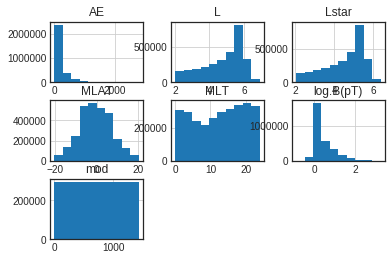

In [10]:
# Generate the histograms
#fig = plt.figure(dpi=120, figsize=(6,6))
_ = dat[inputs+outputs].hist()
#fig.subplots_adjust(wspace=0.5, hspace=0.5)

/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


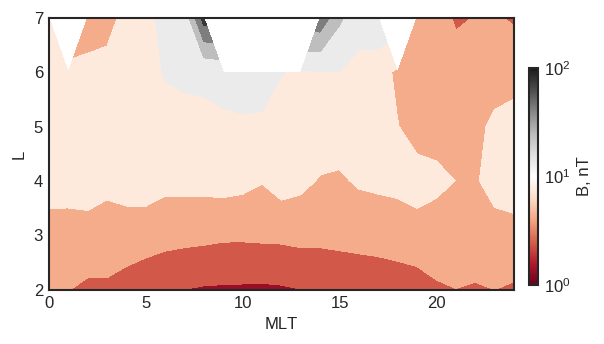

In [18]:
fig = plt.figure(dpi=120, figsize=(5,3))
ax = fig.add_subplot(111)
x, y, z = get_gridded_parameters(dat, "MLT", "L", outputs[0])
contour_f(x, y, z, fig, ax, xlab="MLT", ylab="L")